In [1]:
!pip install -q peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.2 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers.utils import logging
logging.set_verbosity_error()
import os
from torch.nn.utils.rnn import pad_sequence
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm, trange
from transformers import AutoModelWithLMHead, AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

# Загрузка дасета и EDA

In [2]:
#Используем датасет с kaggle использованный для решения похожей задачи https://www.kaggle.com/code/jahysama/hey-lois-i-m-a-chatbot
!wget https://gitlab.com/kostyuk93work/mipt_gennlp_chatbot_1/-/raw/5e87f65e6e49c370e22208c3d9f6fc5f086a8f55/data/Family_guy_dialog.csv

--2024-03-10 15:59:12--  https://gitlab.com/kostyuk93work/mipt_gennlp_chatbot_1/-/raw/5e87f65e6e49c370e22208c3d9f6fc5f086a8f55/data/Family_guy_dialog.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118113 (115K) [text/plain]
Saving to: ‘Family_guy_dialog.csv’

Family_guy_dialog.c 100%[===================>] 115.34K  --.-KB/s    in 0.006s  

2024-03-10 15:59:12 (17.9 MB/s) - ‘Family_guy_dialog.csv’ saved [118113/118113]



character                                             dialog   seasons
0    Stewie   Damn you, vile woman! Youve impeded my work s...  season 1
1    Stewie                                     Hello, Mother.  season 1
2      Lois                          Well, hi, there, sweetie!  season 1
3    Stewie   You know, Mother, life is like a box of choco...  season 1
4    Stewie   Now, I offer you one last chance for deliverance  season 1

character  dialog    seasons
count       1377    1377       1377
unique         9    1285         11
top        Peter   What?  season 12
freq         394       9        217

character            
Peter                    394
Stewie                   269
Brian                    211
Lois                     184
Chris                    113
Meg                       85
Quagmire                  78
Cleveland                 40
Maids and Butlers M&B      3
dtype: int64

Fraction of responses within the response distance    0.893401
dtype: float64


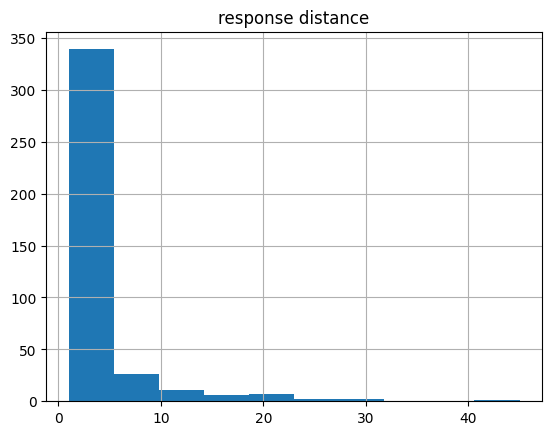

In [3]:
data = pd.read_csv('Family_guy_dialog.csv')
display(data.head())
display(data.describe())
display(data[['character']].value_counts())

#Будем приводить к виду целевая реплика и 6 предшествующих. Посмотрим какая часть датасета лежит внутри 7 реплик между репликами целевого персонажа
CHARACTER_NAME = 'Peter'
response_window = 7

character_response_distance = []
index_left = 0
for index, row in data.iterrows():
    if row['character'] == CHARACTER_NAME:
        character_response_distance.append(index - index_left)
        index_left = index

character_response_distance_df = pd.DataFrame(character_response_distance,columns=['response distance'])
character_response_distance_df.hist()
fraction_of_responses_within_window = character_response_distance_df[character_response_distance_df['response distance'] <= response_window].count() / character_response_distance_df.count()
print(f'Fraction of responses within the {fraction_of_responses_within_window}')

~ 90% датасета попадают в пределах 7 реплик от целевого персонажа.

Надо сказать что результирующий датасет не на 100% чистый, помимо реплик в нем также описываются действия персонажей. Например вот здесь:
"Canada sucks! Peter has a flashback of when he was on Jeopardy!"
Но с учетом того, что задание учебное думаю их вычищать не стоит. Ведь они таже работают как контекст.

In [4]:
#Приводим к виду целевая реплика и 1 предшествующих
CHARACTER_NAME = 'Peter'

contexted = []
n_context = 7

for i in data[data['character'] == CHARACTER_NAME].index:
    if i < n_context:
        continue #remove if a context is less than 7 phrases

    prev = i - 1 - n_context
    row = []
    for j in range(i,prev,-1):
        row.append(data['dialog'][j])
    contexted.append(row)

columns = ['response', 'context']
columns = columns + ['context/' + str(i) for i in range(n_context-1)]

df = pd.DataFrame(contexted,columns=columns)

In [5]:
pd.set_option('display.max_colwidth', None)
df.head(5)

response  \
0   after losing his Cheesy Charlies reservation Chris, this is a big day for you. Today you become the man of the house, because when we get home, your mother is going to kill me.   
1                                                                                                          I cant even watch TV anymore. All the shows are starting to run together.   
2                                                                                                                                          Look, Chris. Its a whole family of wasps.   
3                                                                                                                    Canada sucks! Peter has a flashback of when he was on Jeopardy!   
4                                                    rings in Diarrhea. the crowd laughs What? Oh. Oh. Oh. Sorry. Sorry. What is diarrhea? after seeing the news about the heat wave   

                                                                                                                 context  \
0   in his diary Day 171. Ive sprouted another finger. Counting the one from yesterday, looks at his penis, Im up to 11.   
1                                   No, its not all right! For the love of God, shake me, shake me like a British Nanny!   
2                                                                                                         Uh, you first.   
3                                                                              Look, Chris. Its a whole family of wasps.   
4                                                        Canada sucks! Peter has a flashback of when he was on Jeopardy!   

                                                                          context/0  \
0                                                  Well then, my goal becomes clear   
1   Oh honey, I know youre hurting, but Mommy has to clean up the house, all right?   
2                                                            So, do you like music?   
3                                                                    Uh, you first.   
4                                         Look, Chris. Its a whole family of wasps.   

                                                                                                                        context/1  \
0                                                                     Honey, its not gonna go away just because you dont like it.   
1                                                                                 Very well then. I order you to kill me at once!   
2   Gosh, Id like to help you, Peter, but uh, Ive gotta go out in the hall and chew on the back of my ass for about five minutes.   
3                                                                                                          So, do you like music?   
4                                                                                                                  Uh, you first.   

                                                                                                                        context/2  \
0               Very well then. ILois shoves the broccoli into his mouth. Stewie spits it out. Who the hell do you think you are?   
1                                                             Oh, youre just teething, Stewie, its a normal part of a babys life.   
2                                                       I cant even watch TV anymore. All the shows are starting to run together.   
3   Gosh, Id like to help you, Peter, but uh, Ive gotta go out in the hall and chew on the back of my ass for about five minutes.   
4                                                                                                          So, do you like music?   

                                                                                                                                           context/3  \
0                                                

In [7]:
#В "обучающей" выборке всего 394 предложения
len(df)

394

# Обработка данных

Подготовимд данные для тренировки модели

токенизированный контекст + eos vs токенизированный результат

array([[<Axes: title={'center': '0'}>]], dtype=object)

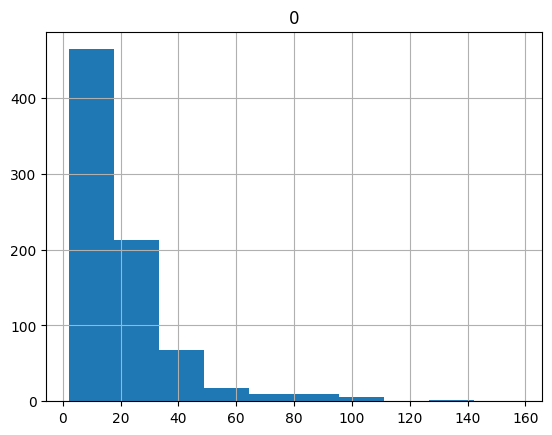

In [11]:
tokens_len_list = []

for index, row in df.iterrows():

  for text in row:
    tokenized_text = tokenizer.encode(text, return_tensors='pt')
    tokens_len_list.append(tokenized_text.shape[-1])

pd.DataFrame(tokens_len_list).hist()

Достаточно будет сделать токенайзер на 256 токенов

In [28]:
class PeterDialogDataset(Dataset):
    def __init__(self, tokenizer, contexts, replies, max_length=256):
        self.tokenizer = tokenizer
        self.contexts = contexts
        self.replies = replies
        self.max_length = max_length

    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, idx):
        context = self.contexts[idx]
        reply = self.replies[idx]

        # Токенизация контекста и ответа
        encoded_context = self.tokenizer.encode_plus(
            context,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        encoded_reply = self.tokenizer.encode_plus(
            reply,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Подготовка labels для ответов
        # Важно: для обучения labels должны быть сдвинуты на один токен вперед
        labels = encoded_reply['input_ids']
        labels[labels == self.tokenizer.pad_token_id] = -100  # Игнорирование PAD токенов при подсчете потерь

        return {
            'input_ids': encoded_context['input_ids'].squeeze(),
            'attention_mask': encoded_context['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

def init_data_loaders(df: pd.DataFrame, batch_size=12, tokenizer=tokenizer,max_length=256):
    dataset = PeterDialogDataset(tokenizer,df['context'].to_list(), df['response'].to_list(),max_length)
    sampler = RandomSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return dataloader

In [29]:
train_text, test_text = train_test_split(df, test_size = 0.2, random_state=2029)
train_dataloader, val_dataloader = init_data_loaders(train_text), init_data_loaders(test_text)

# Инициализация модели и обучение

In [ ]:
def plot_losses(train_loss, valid_loss):
    """
    Рисует графики обучающей и валидационной потерь.

    Параметры:
    - train_loss: список потерь на обучающем наборе.
    - valid_loss: список потерь на валидационном наборе.
    """
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(10, 6))  # Задаём размер графика
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')  # График обучающей потери
    plt.plot(epochs, valid_loss, label='Validation Loss', marker='x')  # График валидационной потери
    plt.title('Training and Validation Loss')  # Название графика
    plt.xlabel('Epoch')  # Подпись оси X
    plt.ylabel('Loss')  # Подпись оси Y
    plt.legend()  # Легенда
    plt.grid(True)  # Добавляем сетку для удобства восприятия
    plt.show()  # Отображаем график

output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [7]:
trn_df, val_df = train_test_split(df, test_size=0.1)

In [8]:
# create dataset suitable for our model
def construct_conv(row, tokenizer, eos = True):
    flatten = lambda l: [item for sublist in l for item in sublist]
    conv = list(reversed([tokenizer.encode(x) + [tokenizer.eos_token_id] for x in row]))
    conv = flatten(conv)
    return conv

class ConversationDataset(Dataset):
    def __init__(self, tokenizer, df, block_size=512):

        block_size = block_size - (tokenizer.model_max_length - tokenizer.max_len_single_sentence)

        self.examples = []
        for _, row in df.iterrows():
            conv = construct_conv(row, tokenizer)
            self.examples.append(conv)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

In [39]:
batch_size = 4
num_train_epochs = 12
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=5e-5
eps=1e-8

In [10]:
def collate(examples):
    if tokenizer._pad_token is None:
        return pad_sequence(examples, batch_first=True)
    return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

In [26]:
def train(train_dataloader, model, tokenizer):
    """ Train the model """
    tr_loss = 0.0
    train_step = 0

    epoch_iterator = tqdm(train_dataloader, desc="Iteration")

    for step, batch in enumerate(epoch_iterator):

        inputs, labels = (batch, batch)
        if inputs.shape[1] > 1024: continue
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.train()
        outputs = model(inputs, labels=labels)
        loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

        loss.backward()
        tr_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        model.zero_grad()
        train_step += 1

    return tr_loss / train_step


def evaluate(model, tokenizer, eval_dataset):

    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(
        eval_dataset, sampler=eval_sampler, batch_size=batch_size, collate_fn=collate, drop_last = True
    )

    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    return eval_loss / nb_eval_steps

In [42]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

model.to(device)

train_dataset = ConversationDataset(tokenizer,trn_df)
eval_dataset = ConversationDataset(tokenizer,val_df)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler, batch_size=batch_size, collate_fn=collate, drop_last = True
)


t_total = len(train_dataloader) * num_train_epochs
model.resize_token_embeddings(len(tokenizer))

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0,
    },
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]

optimizer = AdamW(optimizer_grouped_parameters,lr=lr, eps=eps)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=t_total
)

global_step = 0
epochs_trained = 0


train_loss = []
valid_loss = []
best_valid_loss = float('inf')


train_iterator = trange(epochs_trained, int(num_train_epochs), desc="Epoch")

for _ in train_iterator:
    print('\n Epoch {:} / {:}'.format(epochs_trained + 1, num_train_epochs))

    train_loss_step = train(train_dataloader, model, tokenizer)
    valid_loss_step = evaluate(model, tokenizer, eval_dataset)

    train_loss.append(train_loss_step)
    valid_loss.append(valid_loss_step)


    # # Сохранение модели при улучшении на валидации
    # if valid_loss_step < best_valid_loss:
    #     best_valid_loss = valid_loss_step
    #     torch.save(model.state_dict(), 'saved_weights.pt')

    print(f'\nTraining Loss: {train_loss_step:.3f}')
    print(f'Validation Loss: {valid_loss_step:.3f}')

    # Сохранение модели после каждой эпохи
    epoch_save_path = os.path.join('output', f"model_epoch_{epochs_trained + 1}.pt")
    torch.save(model.state_dict(), epoch_save_path)
    # print(f"Модель сохранена в {epoch_save_path}")

    epochs_trained += 1



Epoch:   0%|          | 0/12 [00:00<?, ?it/s]


 Epoch 1 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 3.909
Validation Loss: 2.545

 Epoch 2 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 2.551
Validation Loss: 2.162

 Epoch 3 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 2.113
Validation Loss: 1.926

 Epoch 4 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.822
Validation Loss: 1.740

 Epoch 5 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.590
Validation Loss: 1.606

 Epoch 6 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.408
Validation Loss: 1.504

 Epoch 7 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.253
Validation Loss: 1.418

 Epoch 8 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.149
Validation Loss: 1.364

 Epoch 9 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.070
Validation Loss: 1.332

 Epoch 10 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 1.020
Validation Loss: 1.301

 Epoch 11 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.948
Validation Loss: 1.287

 Epoch 12 / 12


Iteration:   0%|          | 0/88 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]


Training Loss: 0.948
Validation Loss: 1.279


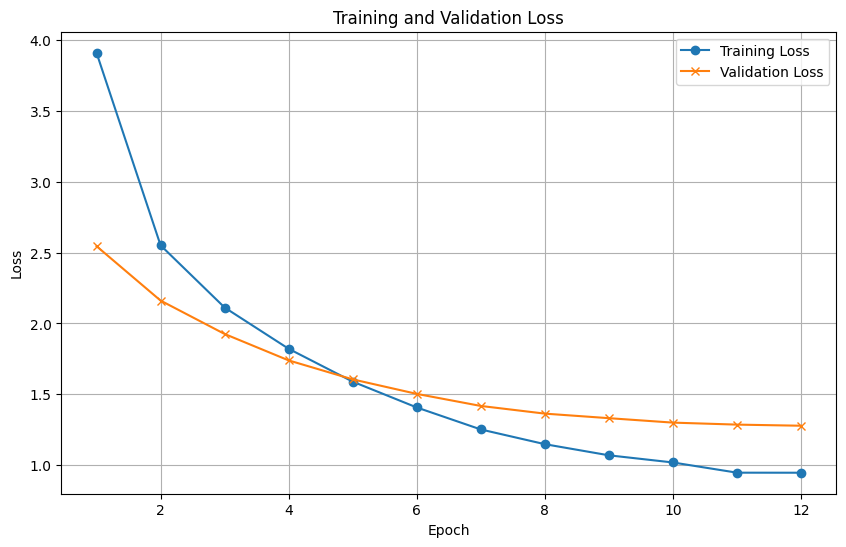

In [43]:
plot_losses(train_loss, valid_loss)


# Загружаем наиболее удачную модель и используем ее как чат бот

In [44]:
model_path = 'output/model_epoch_6.pt'  # Замените X на номер эпохи модели, которую вы хотите загрузить

# Убедитесь, что модель и токенизатор были инициализированы с теми же параметрами, что и при обучении
model = AutoModelWithLMHead.from_pretrained("microsoft/DialoGPT-small")

# Загрузка весов модели
model.load_state_dict(torch.load(model_path))

model.to(device)  # Переместите модель на нужное устройство, например, на GPU, если она доступна

print(f"Модель загружена из {model_path}")


Модель загружена из output/model_epoch_6.pt


In [46]:
# Let's chat for 6 lines
for step in range(6):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input("User:") + tokenizer.eos_token, return_tensors='pt').to(device)
    # print(new_user_input_ids)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens,
    chat_history_ids = model.generate(
        bot_input_ids, max_length=10000,
        pad_token_id=tokenizer.eos_token_id,
        no_repeat_ngram_size=3,
        do_sample=True,
        top_k=100,
        top_p=0.7,
        temperature=0.8
    )

    # pretty print last ouput tokens from bot
    print("Peter: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

User:Hello, let's talk
Peter:  Peter, where have you been?
User:I was at the mall, buying groceries.
Peter:  Hey, why dont you take Joe along?
User:Because he is a cripple!
Peter:  What the hell does "Joe"?
User:what?
Peter:  about Joe.
User:That makes no sense
Peter:  laughs Oh, yeah?
User:yes
Peter: !!!!!!YES!!


# Модель PEFT (не удачная итерация)

In [42]:

tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


In [43]:
print(sum(param.numel() for param in model.parameters() if param.requires_grad), "trainable parameters in model")
for param in model.parameters():
    param.requires_grad = False
print(sum(param.numel() for param in model.parameters() if param.requires_grad), "trainable parameters in model")

124439808 trainable parameters in model
0 trainable parameters in model


In [44]:
from peft import LoraConfig, get_peft_model, IA3Config,  TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["attn.c_attn", "attn.c_proj"],
    # target_modules=["attention.self.query", "attention.self.key", "attention.self.value","attention.output.dense"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

peft_model = get_peft_model(model, lora_config)
print(sum(param.numel() for param in peft_model.parameters() if param.requires_grad), "trainable parameters in model")

442368 trainable parameters in model


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:861: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


# Обучение PEFT (не удачная итерация)

In [30]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [31]:
def train(model, train_dataloader, optimizer, device):
    model.train()
    total_loss = 0

    for step, batch in enumerate(tqdm(train_dataloader)):
        # Перемещение данных на то же устройство, что и модель
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        model.zero_grad()
        outputs = peft_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss = total_loss + loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [32]:
def evaluate(model, val_dataloader, device):
    model.eval()
    total_loss = 0

    for step, batch in enumerate(tqdm(val_dataloader)):
        # Перемещение данных на то же устройство, что и модель
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    avg_loss = total_loss / len(val_dataloader)
    return avg_loss


In [47]:
best_valid_loss = float('inf')

epochs = 2
optimizer = AdamW(peft_model.parameters(), lr=3e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
peft_model.to(device)

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss = train(peft_model, train_dataloader, optimizer, device)
    valid_loss = evaluate(peft_model, val_dataloader, device)

    # Сохранение модели при улучшении на валидации
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(peft_model.state_dict(), 'saved_weights.pt')

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


cuda

 Epoch 1 / 2


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


Training Loss: 14.389
Validation Loss: 14.812

 Epoch 2 / 2


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]


Training Loss: 13.996
Validation Loss: 14.372


In [48]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt').to(device)

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens,
    chat_history_ids = peft_model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User:Рш
DialoGPT: 
>> User:HI!
DialoGPT: 
>> User:Speak to me
DialoGPT: I'm here
>> User:What's your name?
DialoGPT: I'm here
>> User:
DialoGPT: I'm here


In [2]:
list(reversed([i for i in range(10)]))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]